In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Load data (assuming it's in a DataFrame called 'df')
df = pd.read_csv('updated_model_features_1.csv')

df.drop(['Prospect ID'], axis=1, inplace=True)
# Separate features and target
X = df.drop('Converted', axis=1)
y = df['Converted']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Define model with increased max_iter for convergence
lr = LogisticRegression(max_iter=5000, random_state=42)

# Define VALID parameter combinations
param_dist = [
    {
        'penalty': ['l1'],
        'C': loguniform(1e-4, 100),
        'solver': ['liblinear', 'saga'],  # Only these support L1
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['l2'],
        'C': loguniform(1e-4, 100),
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear'],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['elasticnet'],
        'C': loguniform(1e-4, 100),
        'solver': ['saga'],  # Only saga supports elasticnet
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': [None],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'class_weight': [None, 'balanced']
    }
]

# Random search with error handling
lr_random = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=50,  # Reduced from 100 to speed up given more complex grid
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='roc_auc',
    error_score='raise'  # Will show full errors if any
)

try:
    lr_random.fit(X_train_scaled, y_train)
    print("Best parameters for Logistic Regression:", lr_random.best_params_)
except Exception as e:
    print(f"Error during fitting: {str(e)}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Logistic Regression: {'C': 0.0250706636439167, 'class_weight': 'balanced', 'l1_ratio': 0.7, 'penalty': 'elasticnet', 'solver': 'saga'}


In [12]:

from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Define model and search space
rf = RandomForestClassifier()
search_spaces = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 20),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2', None]),
    'bootstrap': Categorical([True, False]),
    'class_weight': Categorical([None, 'balanced', 'balanced_subsample'])
}

# Bayesian optimization
rf_bayes = BayesSearchCV(
    estimator=rf,
    search_spaces=search_spaces,
    n_iter=50,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='roc_auc'
)
rf_bayes.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters for Random Forest:", rf_bayes.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [22]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import re

# Function to clean column names
def clean_column_name(name):
    return re.sub(r'[^a-zA-Z0-9_]', '_', name)

# Rename columns
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]

def objective_cv(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)

    # Using cross-validation instead of eval_set
    scores = cross_val_score(model, X_train, y_train,
                           cv=5, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study_cv = optuna.create_study(direction='maximize')
study_cv.optimize(objective_cv, n_trials=50)
print("Best parameters (CV version):", study_cv.best_params)

[I 2025-04-03 23:42:37,337] A new study created in memory with name: no-name-0ce8357e-d5ad-423d-af54-6d3920798b1e
[I 2025-04-03 23:42:39,446] Trial 0 finished with value: 0.9093738528742297 and parameters: {'n_estimators': 247, 'learning_rate': 0.23654324271114968, 'num_leaves': 102, 'max_depth': 10, 'min_child_samples': 55, 'subsample': 0.8895224238850852, 'colsample_bytree': 0.8307565199617466, 'reg_alpha': 6.311379240483897, 'reg_lambda': 6.391035358953168}. Best is trial 0 with value: 0.9093738528742297.
[I 2025-04-03 23:42:42,409] Trial 1 finished with value: 0.9067999025858814 and parameters: {'n_estimators': 175, 'learning_rate': 0.21070313396578572, 'num_leaves': 118, 'max_depth': 10, 'min_child_samples': 77, 'subsample': 0.6140516382576853, 'colsample_bytree': 0.8151648983858675, 'reg_alpha': 0.6976904429115915, 'reg_lambda': 4.017227460189581}. Best is trial 0 with value: 0.9093738528742297.
[I 2025-04-03 23:42:43,487] Trial 2 finished with value: 0.9009748277128722 and param

Best parameters (CV version): {'n_estimators': 92, 'learning_rate': 0.1572160192541681, 'num_leaves': 127, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.7786220767144109, 'colsample_bytree': 0.9435739354316376, 'reg_alpha': 2.487905004694599, 'reg_lambda': 2.1033598112236866}


In [24]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Enhanced evaluation function with error handling"""
    try:
        # Training with verbosity control
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        return metrics
    except Exception as e:
        print(f"Error evaluating {type(model).__name__}: {str(e)}")
        return None

# First ensure LightGBM study completed successfully
try:
    if not study.trials:
        print("Running LightGBM optimization...")
        study.optimize(objective, n_trials=50)  # Run optimization if not done
    elif study.best_trial is None:
        print("No successful trials - retrying with simpler parameters...")
        # Fallback to default parameters if optimization failed
        lgbm_model = lgb.LGBMClassifier(random_state=42)
    else:
        lgbm_model = lgb.LGBMClassifier(**study.best_params)
except Exception as e:
    print(f"LightGBM optimization failed: {str(e)}")
    lgbm_model = lgb.LGBMClassifier(random_state=42)  # Fallback to defaults

# Prepare models dictionary
models = {
    'Logistic Regression': lr_random.best_estimator_,
    'Random Forest': rf_bayes.best_estimator_,
    'LightGBM': lgbm_model
}

# Evaluate all models
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    result = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    if result is not None:
        results[name] = result
        print(f"{name} Performance:")
        print(pd.Series(result).drop('confusion_matrix'))
    else:
        print(f"Failed to evaluate {name}")

# Display final results
if results:
    print("\nFinal Model Performance Comparison:")
    results_df = pd.DataFrame(results).T
    display(results_df.drop(columns='confusion_matrix'))
else:
    print("No models were successfully evaluated")

LightGBM optimization failed: name 'study' is not defined

Evaluating Logistic Regression...
Logistic Regression Performance:
accuracy     0.794913
precision    0.751891
recall       0.698034
f1           0.723962
roc_auc       0.86053
dtype: object

Evaluating Random Forest...
Random Forest Performance:
accuracy     0.818723
precision     0.78691
recall       0.726124
f1           0.755296
roc_auc      0.880308
dtype: object

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 2849, number of negative: 4543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 7392, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.385417 -> initscore=-0.466620
[LightGBM] [Info] Start training from score -0.466620
LightGBM Performance:
accuracy      0.82197
precision   

C:\Users\varsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\varsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.794913,0.751891,0.698034,0.723962,0.86053
Random Forest,0.818723,0.78691,0.726124,0.755296,0.880308
LightGBM,0.82197,0.804452,0.710674,0.754661,0.881875


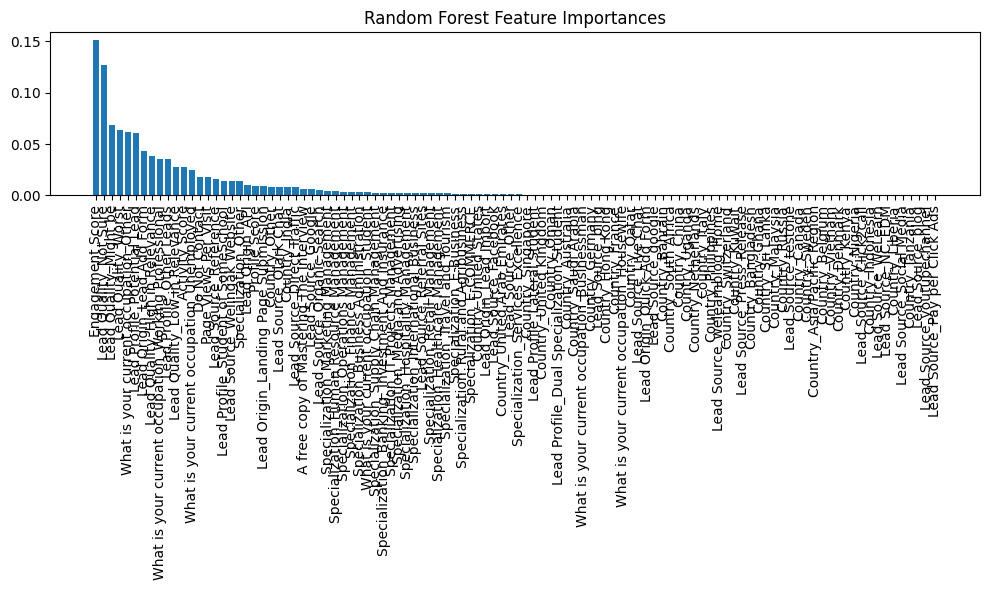

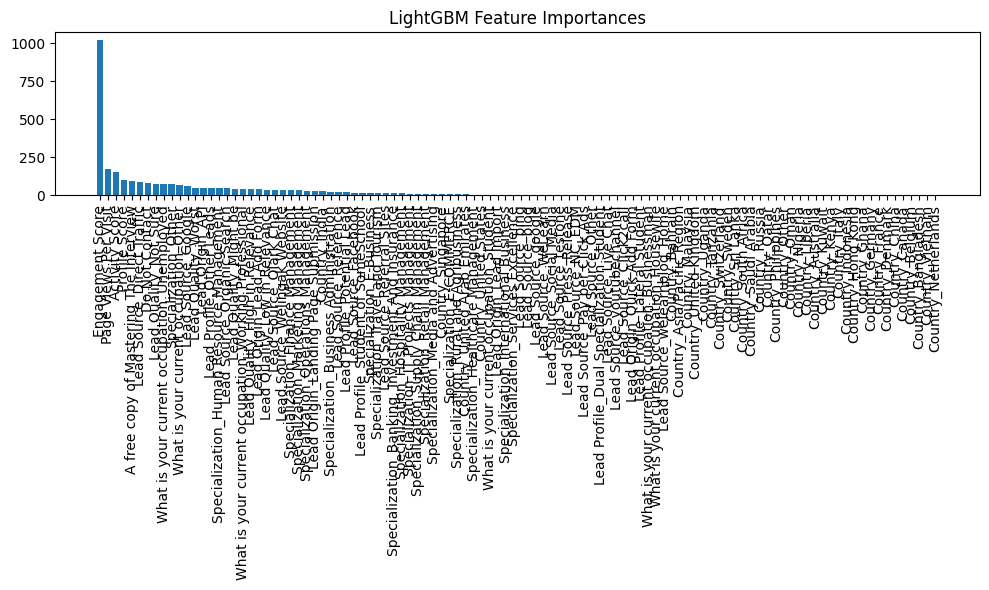

In [25]:
import matplotlib.pyplot as plt

# For tree-based models
for name in ['Random Forest', 'LightGBM']:
    if hasattr(models[name], 'feature_importances_'):
        importances = models[name].feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title(f"{name} Feature Importances")
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
        plt.tight_layout()
        plt.show()

In [26]:
import joblib

# Select best model based on ROC AUC
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = models[best_model_name]

print(f"\nBest model is {best_model_name} with ROC AUC: {results[best_model_name]['roc_auc']:.4f}")

# Save the best model
joblib.dump(best_model, 'best_lead_conversion_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


Best model is LightGBM with ROC AUC: 0.8819


['scaler.pkl']